# **Plant Images Classificaiton**

Date: 26/09/2022

Contact: potchara.wongyai@gmail.com

Program: Data Science BootCamp

Institution: BrainStation, Toronto, Ontario

## **Table of Contents**
1. [__Introduction__](#sec1)
2. [__Business Objective__](#sec2)
3. [__Notebook Setup__](#sec3)
4. [__Dataset Review__](#sec4)
    - 4.1 [Reading-in Dataset](#sec41)
    - 4.2 [Cleaning](#sec42)
    - 4.3 [EDA](#sec43)
5. [__Dataset Preparation for Modelling__](#sec5)
    - 5.1 [Unit Conversion](#sec51)
    - 5.2 [Train / Validation / Test Split](#sec52)
6. [__Modelling__](#sec6)
    - 6.1 [MODEL1](#sec61)
    - 6.2 [MODEL2](#sec62)
    - 6.3 [Combined Model](#sec63)
7. [__Evaluation__](#sec7)
8. [__Explore Image Techniques__](#sec8)
    - 8.1 [Baseline](#sec81)
    - 8.2 [Edge Detection Filter](#sec82)
    - 8.3 [Sharpen Filter](#sec83)
    - 8.4 [Grey Scale](#sec84)
    - 8.5 [Grey Scale with Green Enhanced](#sec85)
9. [__Conclusions__](#sec9)
10. [__Recommendations__](#sec10)

## **1) Introduction**<a class="anchor" id="sec1"></a>

The goal of this project is to classify images of plant seedlings from 12 species. The methodology used for data reviewing, cleaning, Exploratory Data Analysis (EDA), modelling and evaluating models will be demonstrated in this notebook.

## **2) Business Objective**<a class="anchor" id="sec2"></a>



This project was inspired by an intelligence farming system being developped by the author. The models and methodology developped from this project will be applied to a prototype farm in Chiang Rai, Thailand, which will begin in 2023. The use case of plant images classification is when a camera drone automatically identify the type of plants instead of a human, in order to reduce the amount of physical labor and cost. For future applications, the images classified will be used to monitor plant growths and optimize nutrition required for each type of plants in the prototype farm.

## **3) Notebook Setup**<a class="anchor" id="sec3"></a>

<u>Before running this notebook</u>:
- Please ensure the following files are saved in the same directory as this notebook:

  - `X-Plant-224.npy`
  - `y-Plant-224.npy`
  - `lv1_model` (folder with files)
  - `lv1_model_weight.hdf5`
  - `lv1_model_history.pkl`
  - `lv2_model` (folder with files)
  - `lv2_model_weight.hdf5`
  - `lv2_model_history.pkl`

- This notebook require a large amount of RAM and GPU. Recommend to run a machine that support at least 32GB of RAM and 24GB of GPU. Note, the notebook was created in Google Colab Pro+. 

- **Note:** The parallel process on GPU introdcues some randomness, so the models generated in this notebook are unable to be replicated exactly.

Below are the required libraries to run this notebook.

In [ ]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random as rn
import os
import cv2
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Import Tensorflow and Keras libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout

We attempt to reduce randomness during the model development as much as possible following a guideline from Keras. 

https://keras.io/getting_started/faq/#how-can-i-obtain-reproducible-results-using-keras-during-development

In [ ]:
# Settinn Random Seed for Python Numpy TensorFlow
os.environ['PYTHONHASHSEED'] = '0'

# The below is necessary for starting Numpy generated random numbers.
np.random.seed(123)

# The below is necessary for starting core Python generated random numbers.
rn.seed(123)

# The below set_seed() will make random number generation in the TensorFlow.
tf.random.set_seed(1234)

## **4) Dataset Review**<a class="anchor" id="sec4"></a>

### **4.1) Reading-in Dataset**<a class="anchor" id="sec41"></a>

The dataset is obtained from a Kaggle competion launched in 2017, which includes images of plant seedlings in 12 species at various stages of growth. There are 4,750 training images with labels, and 974 testing images without labels. Only the 4,750 training images will be used in this project.
- (https://www.kaggle.com/c/plant-seedlings-classification). 

Note, the images were originally produced by the Aarhus University Signal Processing group, in collaboration with University of Southern Denmark.
- (https://vision.eng.au.dk/plant-seedlings-dataset/).


The dataset was pre-cleaned in a seperate notebook `Plant_Images_Import_Clean.ipynb` and saved as numpy arrays. In the pre-cleaning, black backgrounds were added to ensure all images maintain the aspect ratio of 1, and minimize distortion. The images were resized to 224 x 224 pixels.

From pre-cleaning, the images were saved in `X-Plant-224.npy`, and labels were saved in `y-Plant-224.npy`. We can load in the dataset by running the code below. Note, we will also convert all class labels to ingeters, so they are compatible with the  `sparse_categorical_crossentropy` loss function that we will use later on.

|Class Name|Class Numbers|
|--|:--:|
|Black-grass|0|
|Charlock|1|
|Cleavers|2|
|Common Chickweed|3|
|Common wheat|4|
|Fat Hen|5|
|Loose Silky-bent|6|
|Maize|7|
|Scentless Mayweed|8|
|Shepherds Purse|9|
|Small-flowered Cranesbill|10|
|Sugar beet|11|

In [ ]:
# read-in pre-clean training dataset (4,750 image  with labels)
X = np.load('X-Plant-224.npy')
y = np.load('y-Plant-224.npy')

In [ ]:
# define plant classification
classification = ["Black-grass",                  # class 0
                  "Charlock",                     # class 1
                  "Cleavers",                     # class 2
                  "Common Chickweed",             # class 3
                  "Common wheat",                 # class 4
                  "Fat Hen",                      # class 5
                  "Loose Silky-bent",             # class 6
                  "Maize",                        # class 7
                  "Scentless Mayweed",            # class 8
                  "Shepherds Purse",              # class 9
                  "Small-flowered Cranesbill",    # class 10
                  "Sugar beet"]                   # class 11

# convert class names to class numbers
for i in np.arange(len(classification)):
    y = np.where(y == classification[i], i, y)
y = y.astype(int)

### **4.2) Cleaning**<a class="anchor" id="sec42"></a>

We want to ensure the data are in the expected formats and there are no NaN or duplicated images. The strategy used are listed below:

- 1) check data shape and format
- 2) check NaN (missing values)
- 3) check duplication

#### **4.2.1) Check Data Shape and Format**

Using the codes below, we were able to check that:
- X is a numpy array with 4,750 RGB (3 channels) images of 224 x 224 pixels. Each pixel is stored as `uint8`, which accepts values between 0 and 255.  
- y is a numpy array with 4,750 class labels that range between 0 and 11. Each class label is stroed as `int64`.

In [ ]:
# check shapes of X and y
print(f'Shape of X = {X.shape}')
print(f'Shape of y ={y.shape}')

Shape of X = (4750, 224, 224, 3)
Shape of y =(4750,)


In [ ]:
# check variable type
print(f'Type of X = {type(X)}')
print(f'Type of y ={type(y)}')

Type of X = <class 'numpy.ndarray'>
Type of y =<class 'numpy.ndarray'>


In [ ]:
# check variable type
print(f'Data type of X = {X.dtype}')
print(f'Data type of y = {y.dtype}')

Data type of X = uint8
Data type of y = int64


In [ ]:
# check range of values
print(f'Range of X:  min = {X.min()}, max = {X.max()}')
print(f'Range of y:  min = {y.min()}, max = {y.max()}')

Range of X:  min = 0, max = 255
Range of y:  min = 0, max = 11


#### **4.2.2) Check NaN (Missing Values)**

Here, we also checked that there was no NaN value in the dataset.

In [ ]:
# check NaN in X and y
print(f'Number of NaN in X = {np. isnan(X).sum()}')
print(f'Number of NaN in y = {np. isnan(y).sum()}')

Number of NaN in X = 0
Number of NaN in y = 0


#### **4.2.3) Check Duplication**

Comparing each image to identify duplication requires a very high computational resource. To simplify the process, we can crop a small part of the image (20 x 20 pixels) from one of the color channels (e.g. green), and convert those pixels into a dataframe, where duplication can be easily checked. Using this method, we identified 3 duplicated images. 

In [ ]:
# create a numpy array to store crop images
crop_images = np.zeros((len(X), 20, 20), dtype= int)

# set crop location
min_height = int(X.shape[1]/2-10)
max_height = int(X.shape[1]/2+10)
min_width = int(X.shape[2]/2-10)
max_width = int(X.shape[2]/2+10)

# loop though all images and save crop images in "crop_images"
for i in np.arange(len(X)):
    crop_images[i] = X[i, min_height:max_height, min_width:max_width, 1]

# Flatten 2D images to lists
crop_images = crop_images.reshape(len(X),-1)

# save flatten images as a dataframe
dup_check_df = pd.DataFrame(crop_images)

# check duplication
print (f'Number of duplication found = {dup_check_df.duplicated().sum()}')

Number of duplication found = 3


The 3 duplicated images are Image 1653, 1672, and 4607 as shown below. Image 1634 and 4480 will be kept.

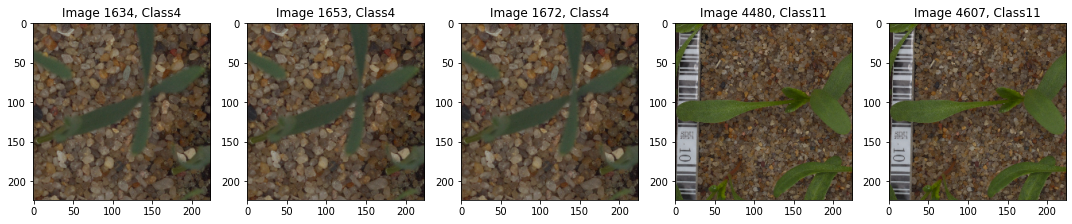

In [ ]:
# list the number of duplicated image in an index
dup_index = dup_check_df[dup_check_df.duplicated(keep = False)].index

# plot all duplicated image from the index
plt.subplots(1,len(dup_index), figsize = (15, 3))
for i in np.arange(len(dup_index)): # iterate by the list of index
    plt.subplot(1,len(dup_index),i+1) # subplot location
    plt.imshow(X[dup_index[i]]) # show image
    plt.title(f'Image {dup_index[i]}, Class{y[dup_index[i]]}') # title

plt.tight_layout()
plt.show()


Once we removed the 3 duplicated images we can double check that there is no more duplication.

In [ ]:
# Delete image 1653, 1672, and 4607 and their labels
X = np.delete(X, [4607], 0)
y = np.delete(y, [4607], 0)

X = np.delete(X, [1672], 0)
y = np.delete(y, [1672], 0)

X = np.delete(X, [1653], 0)
y = np.delete(y, [1653], 0)

In [ ]:
# check number of duplication

# create a numpy array to store crop images
crop_images = np.zeros((len(X), 20, 20), dtype= int)

# set crop location
min_height = int(X.shape[1]/2-10)
max_height = int(X.shape[1]/2+10)
min_width = int(X.shape[2]/2-10)
max_width = int(X.shape[2]/2+10)

# loop though all images and save crop images in "crop_images"
for i in np.arange(len(X)):
    crop_images[i] = X[i, min_height:max_height, min_width:max_width, 1]

# Flatten 2D images to lists
crop_images = crop_images.reshape(len(X),-1)

# save flatten images as a dataframe
dup_check_df = pd.DataFrame(crop_images)

# check duplication
print (f'Number of duplication found = {dup_check_df.duplicated().sum()}')

Number of duplication found = 0


### **4.3) EDA**<a class="anchor" id="sec43"></a>

#### **4.3.1) Check Class Distribution**

From below, we can see the class distribution by the number of images. Class 6 has the highest number of images and and it has over 3 times the images in class 4. Upsampling technique can be employed if the imbalance distribution causes issues during modelling. 

Text(0, 0.5, 'Class')

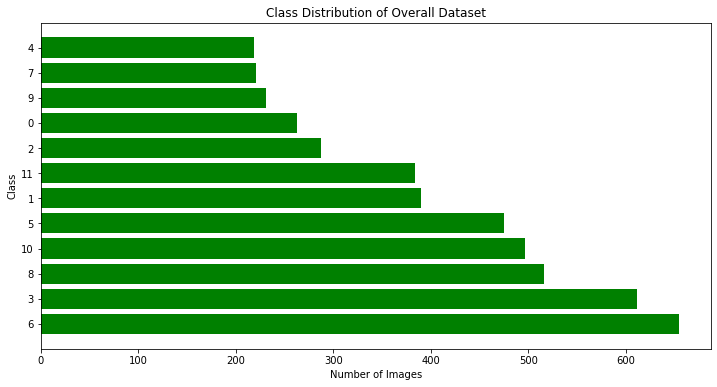

In [ ]:
# plot of class distribution
class_list = pd.Series(y).value_counts().index # list of classes
value_list = pd.Series(y).value_counts().values # list of value counts

# barplot
plt.figure(figsize = (12,6))
plt.barh(class_list.astype(str), value_list, color='green') # change class type to string
plt.title('Class Distribution of Overall Dataset')
plt.xlabel('Number of Images')
plt.ylabel('Class') 

#### **4.3.2) Check Sample Images from Each Class**

Example plant images for each class are shown below. The majority of the classes have distinct features. However, we can see that class 0, 4, and 6 all have very thin leaves, so it is expected that modelling will be difficult. Also, it is noted that some of their images only show part of the leaves, which make can it even harder to tell them apart. From reviewing more images in the dataset, it was noted there are various stages of plant growth. Mostly in the young stage, unique features of the plants are not present, which may contribute to prediction error.

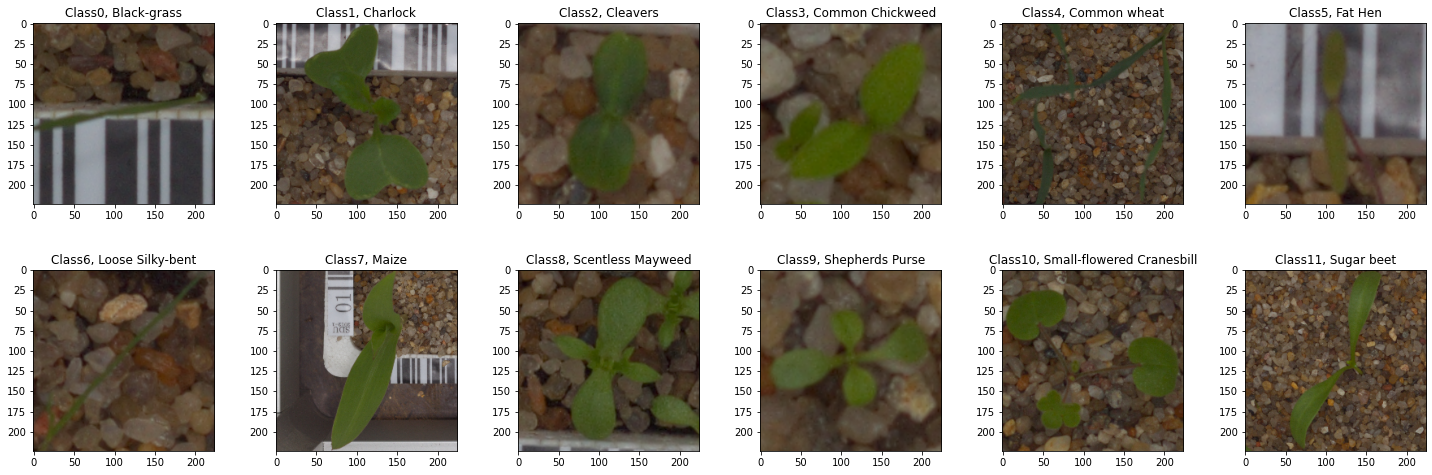

In [ ]:
# plot sample images from each class
y_index=np.arange(len(y)) # index for filtering y

plt.subplots(2,6, figsize = (20, 7))

for i in np.arange(0,12): # iterate from class 1 to 12
    plt.subplot(2,6,i+1) # subplot location
    plt.imshow(X[y_index[y==i][0]]) # show the first image of each class encountered in the dataset 
    plt.title(f'Class{i}, {classification[i]}') # title

plt.tight_layout()
plt.show()

## **5) Dataset Preparation for Modelling**<a class="anchor" id="sec5"></a>

### **5.1) Unit Conversion**<a class="anchor" id="sec51"></a>

The image data is converted from the range between 0 - 255, to the range between 0 - 1. This is to help reduce the variance and for the models to train more efficiently. The data type of **X** changes from `uint8` to `float32` since it now contains decimal places.

In [ ]:
# normalize image to the range between 0 & 1
X = X.astype('float32')
X /= 255

### **5.2) Train / Validation / Test Split**<a class="anchor" id="sec52"></a>

In this step, we are splitting the dataset into 70% train, 15% validation and 15% test. The remainder dataset (or test + validation) is also created in order run the K-fold cross validation.

In [ ]:
from sklearn.model_selection import train_test_split
#split the dataset into: 85% train 15% test

# Split 85/15  between remainder and test
X_rem, X_test, y_rem, y_test = train_test_split(X, y, test_size=0.15, stratify=y, random_state=111)

# Split 75/15  between train and val
X_train, X_val, y_train, y_val = train_test_split(X_rem, y_rem, test_size=0.1764, stratify=y_rem, random_state=150)

## **6) Modelling**<a class="anchor" id="sec6"></a>

CNN modelling can be carried out in numbers of ways, since there are many  techniques that can be applied. Fine-tuning a CNN model for production can realistically take months or years. In this project, techniques below were experimented in order to achieve a reasonable model performance.

- ImageDataGenerator
- Upsampling
- Changing learning rate
- Different CNN layers
- Transfer learning

Through trials and errors with the techniques above **MODEL1** and **MODEL2** were created.

### **6.1) MODEL1**<a class="anchor" id="sec61"></a>

The task of the first model is to classify images into 12 classes. In this model, ImageDataGenertor is applied to improve the prediction accuracy.  The parameters used for ImageDataGenerator include:

- shear_range: shear intensity ( or shear angle in counter-clockwise direction in degrees)
- zoom_range: range for random zoom
- horizontal_flip: randomly flip image horizontally

The train and validation datasets were used to optimize the model, while the remainder dataset (train + validation) was used to cross-validate with K-fold cross validation.





In [ ]:
# apply ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Initialize training image data generator.
train_datagen = ImageDataGenerator(shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

# Initializevalidation image data generator.
validation_datagen = ImageDataGenerator()

# Create train/validation generator
train_generator=train_datagen.flow(X_train, y_train, batch_size=50)
validation_generator=validation_datagen.flow(X_val, y_val, batch_size=50)

**MODEL1** is constructed using custom layers shown below.
- Layer 1: 2D convolution layer with 3x3 kernel, 64 nodes, Relu activation
- Layer 2: MaxPooling2D layer with 2x2 kernel
- Layer 3: 20% Dropout layer
- Layer 4: 2D convolution layer with 3x3 kernel, 128 nodes, Relu activation
- Layer 5: MaxPooling2D layer with 2x2 kernel
- Layer 6: 20% Dropout layer
- Layer 7: Flatten layer
- Layer 8: dense layer, 128 nodes (post flatten), Relu activation
- Layer 9: dense layer, 64 nodes, Relu activation
- Layer 10: dense layer, 32 nodes, Relu activation
- Layer 11: dense layer, 12 nodes, SoftMax activation


NOte, the last layer has 12 nodes in oder to classify 12 classes.   


In [ ]:
# Simple CNN model construction

IMAGE_SIZE = (224, 224, 3) # define image size

CNN_model = Sequential() # create sequence

# Create simple CNN model architecture with Pooling for dimensionality reduction 
# and Dropout to reduce overfitting
CNN_model.add(Conv2D(64, kernel_size=(3, 3), activation = 'relu', input_shape = IMAGE_SIZE))
CNN_model.add(MaxPooling2D(pool_size=(2, 2)))
CNN_model.add(Dropout(0.2))

CNN_model.add(Conv2D(128, (3, 3), activation='relu'))
CNN_model.add(MaxPooling2D(pool_size=(2, 2)))
CNN_model.add(Dropout(0.20))

# Flatten the output of our convolutional layers
CNN_model.add(Flatten())

# Add dense layers
CNN_model.add(Dense(128, activation='relu'))
CNN_model.add(Dense(64, activation='relu'))
CNN_model.add(Dense(32, activation='relu'))
CNN_model.add(Dense(12, activation='softmax'))

The model is complied as shown below. Note that the learning rate is set to the default value at 0.001.

In [ ]:
# Compile the model with the desired loss function, optimizer, and metric(s) to track
opt = keras.optimizers.Adam(learning_rate=0.001)

CNN_model.compile(loss = 'sparse_categorical_crossentropy',
                  optimizer = opt,
                  metrics = ['accuracy'])

The modelel is fitted with **train_generator** and validate with **validation_generator** to determine the validation accuracy.

In [ ]:
# Fit the model on the training data, defining desired batch_size & number of epochs,
# running validation after each batch
# THIS WILL TAKE A LONG TIME TO RUN!!!
history = CNN_model.fit(train_generator,
              batch_size = 64,
              epochs = 20,
              verbose = 1,
              validation_data=validation_generator)

Epoch 1/20
67/67 [==============================] - 29s 419ms/step - loss: 2.8194 - accuracy: 0.1550 - val_loss: 2.3248 - val_accuracy: 0.2360
Epoch 2/20
67/67 [==============================] - 28s 420ms/step - loss: 2.0086 - accuracy: 0.3341 - val_loss: 1.6613 - val_accuracy: 0.3989
Epoch 3/20
67/67 [==============================] - 29s 428ms/step - loss: 1.5516 - accuracy: 0.4473 - val_loss: 1.5476 - val_accuracy: 0.4466
Epoch 4/20
67/67 [==============================] - 28s 423ms/step - loss: 1.3405 - accuracy: 0.5244 - val_loss: 1.2875 - val_accuracy: 0.5365
Epoch 5/20
67/67 [==============================] - 28s 421ms/step - loss: 1.1820 - accuracy: 0.5939 - val_loss: 1.0767 - val_accuracy: 0.6447
Epoch 6/20
67/67 [==============================] - 28s 420ms/step - loss: 1.0751 - accuracy: 0.6207 - val_loss: 0.9982 - val_accuracy: 0.6545
Epoch 7/20
67/67 [==============================] - 28s 417ms/step - loss: 0.9540 - accuracy: 0.6782 - val_loss: 1.0513 - val_accuracy: 0.6306

For **MODEL1**, the model, weights, and run history were saved into **lv1_model**, **lv1_model_weight.hdf5**, and **lv1_model_history.pkl** respectively. Note, the codes below are commented out since we do not want to overwrite the model. 

In [ ]:
# save model
# model_name = 'lv1_model'
# CNN_model.save(model_name)

# save weight
# weight_name = 'lv1_model_weight.hdf5'
# CNN_model.save_weights(weight_name , overwrite = True)

# save history
# save_history = pd.DataFrame(history.history)
# save_history.to_pickle('lv1_model_history.pkl')

Next, we perform Stratified K-fold cross validation to double check the validation accuracy of **MODEL1**. The CNN model is constructed the same way as we did previously. Ideally, K-fold cross validation is to be used to optize the model. However, the image dataset we are using is large, so each fold takes a very long time to run. Therefore, it is used as a validation method only. The avergae validation accuracy from the k-fold cross validation is 77.2%, which is very close to the validation accuracy of **MODEL1** (77.8%).

In [ ]:
# Rerun with K-fold cross validation
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=5) #set 5 folds
val_acc = [] # empty list
count = 0 # track fold
for train_index, test_index in skf.split(X_rem, y_rem):  # split based on StratifiedKFold
    X_train2, y_train2 = X_rem[train_index], y_rem[train_index] # new training dataset
    X_val2,   y_val2 = X_rem[test_index] , y_rem[test_index] # new testing dataset

    train_generator=train_datagen.flow(X_train2, y_train2, batch_size=50) # create train_generator
    validation_generator=validation_datagen.flow(X_val2, y_val2, batch_size=50) #create validation_generator 

    IMAGE_SIZE = (224, 224, 3) # set input image size

    CNN_model = Sequential() #set model as sequential

    # create CNN model architecture with Pooling for dimensionality reduction  
    # and Dropout to reduce overfitting
    CNN_model.add(Conv2D(64, kernel_size=(3, 3), activation = 'relu', input_shape = IMAGE_SIZE))
    CNN_model.add(MaxPooling2D(pool_size=(2, 2)))
    CNN_model.add(Dropout(0.2))

    # create CNN model architecture with Pooling for dimensionality reduction 
    # and Dropout to reduce overfitting
    CNN_model.add(Conv2D(128, (3, 3), activation='relu'))
    CNN_model.add(MaxPooling2D(pool_size=(2, 2)))
    CNN_model.add(Dropout(0.20))

    # flatten the output of our convolutional layers
    CNN_model.add(Flatten())

    # add dense layers
    CNN_model.add(Dense(128, activation='relu'))
    CNN_model.add(Dense(64, activation='relu'))
    CNN_model.add(Dense(32, activation='relu'))
    CNN_model.add(Dense(12, activation='softmax'))

    # set optimizer and compile model
    opt = keras.optimizers.Adam(learning_rate=0.001)
    CNN_model.compile(loss = 'sparse_categorical_crossentropy',
                  optimizer = opt,
                  metrics = ['accuracy'])
    # fit model
    history = CNN_model.fit(train_generator,
              batch_size = 64,
              epochs = 20,
              verbose = 0,
              validation_data=validation_generator)
  
    # record validation accuracy
    val_acc.append(history.history['val_accuracy'][-1])
    count = count+1
    print(f'validation accuracy of fold {count} is {val_acc[count-1]}') # print accuracy

# print avg validation accuracy
print(f'Avg validation accuracy from 5-fold cross-validation is {np.array(val_acc).mean()}')

validation accuracy of fold 1 is 0.7893432378768921
validation accuracy of fold 2 is 0.7484510540962219
validation accuracy of fold 3 is 0.8004956841468811
validation accuracy of fold 4 is 0.7732341885566711
validation accuracy of fold 5 is 0.7493796348571777
Avg validation accuracy from 5-fold cross-validation is 0.7721807599067688


We can reload **MODEL1** and plot the model loss and model accuracy below. The loss history seems reasonable, since it get smaller in each epoch. The model accuracy also seems reasonable since the validation accuracy is lower than the train accuracy.

In [ ]:
# Load model consistency
LV1_model = keras.models.load_model('lv1_model')
LV1_model.load_weights('lv1_model_weight.hdf5')
LV1_history = pd.read_pickle('lv1_model_history.pkl')

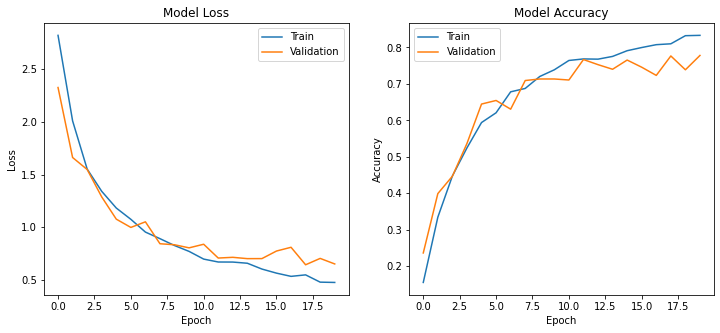

<Figure size 432x288 with 0 Axes>

In [ ]:
# create plots
plt.subplots(1,2, figsize = (12,5))

# plot model loss
plt.subplot(1,2,1)
plt.plot(LV1_history['loss']) # train loss
plt.plot(LV1_history['val_loss']) # validation loss
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])

# plot model accuracy
plt.subplot(1,2,2)
plt.plot(LV1_history['accuracy']) # train accuracy
plt.plot(LV1_history['val_accuracy']) # validation accuracy
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

plt.tight_layout()
plt.show()

The confusion matrix is plotted below based on the test dataset. The numbers shown on the table are the fraction of the total number of images for each class. The majority of the classes were predicted quite well, except for Class 0. Class 0 has an extremely low prediction accuracy largely due to mixing up with Class 6. Therefore, we need to address this issue somehow. 

Note, we identified previously that the plants in Class 0 look similar as Class 6, so getting poor prediction is not surprising.

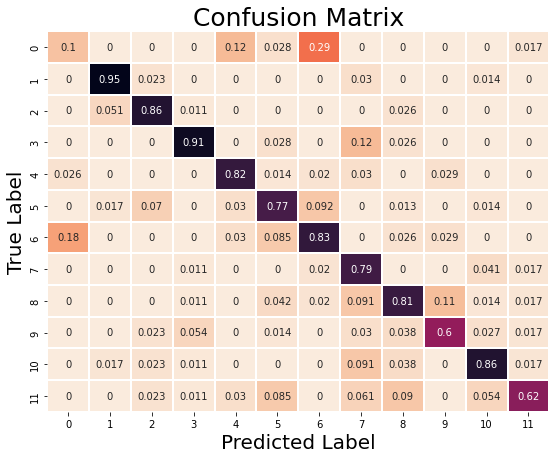

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
#Plot confusion matrix

# Calculate the predicted labels for each test image.
predict_probas = LV1_model.predict(X_test)
y_predict = np.argmax(predict_probas, axis=1)

# Create the confusion matrix using sklearn 
conf_mat = confusion_matrix(y_test, y_predict)

# Since we have many images, it is helpful to show our 
# results as fractions of the total number of images 
# for each class.
normalized_conf_mat = conf_mat / conf_mat.sum(axis=1)

plt.figure(figsize = (9,7))
sns.heatmap(normalized_conf_mat,
            annot=True,
            cbar=False,
            cmap="rocket_r",
            linewidths=1
           )
plt.title('Confusion Matrix',size = 25,y=1.01)
plt.xlabel("Predicted Label", size = 20)
plt.ylabel("True Label", size = 20)
plt.show()

### **6.2) MODEL2**<a class="anchor" id="sec62"></a>

**MODEL2** is created to address poor prediction between Class 0 and Class 6.

The idea is to take all the images predicted by **MODEL1** as Class 0 or Class 6, and pass them thorugh **MODEL2** to classify again. To make **MODEL2** more accurate, we will focus on training only Class 0 and Class 6 from the train dataset. 

Below is the function used to extract the two classes from any given dataset. In this function, the class labels will be converted to 0 and 1 since we are now dealing with a binary problem.

In [ ]:
# function to extract specified classes from datasets and convert labels to binary
def class_pair_extraction(X, y, class1, class2):
    index_12 = [(y == class1) | (y == class2)] # index for class location 
    X_12 = X[index_12] # filtered X
    y_12 = y[index_12] # filtered y
    y_12 = np.where(y_12 == class2, 1, 0)  # convert labels to binary (0 & 1)
    return X_12, y_12

Here we extract the two classes from the datasets created previously, which are the train, validation, remainder, and test datasets.

In [ ]:
# save class 0 and class 6 data in new numpy arrays

X_train_06, y_train_06 =  class_pair_extraction(X_train, y_train, 0, 6)
X_test_06, y_test_06 =  class_pair_extraction(X_test, y_test, 0, 6)
X_val_06, y_val_06 =  class_pair_extraction(X_val, y_val, 0, 6)
X_rem_06, y_rem_06 =  class_pair_extraction(X_rem, y_rem, 0, 6)

When comparing the data distribution between Class 0 and Class 6, we find that the data are very unevenly distributed, where Class 6 has about 2.5 times more datapoints. To balace the dataset, we are going to apply **upsampling** to Class 0. 

In [ ]:
# compare class 0 and class 6 distribution
print(f'Number of train images in Class 0 = {pd.Series(y_train_06).value_counts()[0]}')
print(f'Number of train images in Class 6 = {pd.Series(y_train_06).value_counts()[1]}')
print(f'Ratio of between Class 6 and Class0 = {pd.Series(y_train_06).value_counts()[1]/pd.Series(y_train_06).value_counts()[0]}')

Number of train images in Class 0 = 184
Number of train images in Class 6 = 458
Ratio of between Class 6 and Class0 = 2.489130434782609


Below is the function to upsample a certain class in a given dataset. 

In [ ]:
# function to upsample a specific class in the dataset
from sklearn.utils import resample

def upsampling(n, X_train, y_train, class_name):
    upsample_index = (y_train == class_name) # index to filter class
    X_upsampled, y_upsampled = resample(X_train[upsample_index],  # upsample the data
                                    y_train[upsample_index], 
                                    replace=True, 
                                    n_samples=int(n*upsample_index.sum()), 
                                    random_state=123)
    X_train_bal = np.vstack((X_train[np.invert(upsample_index)], X_upsampled))  # combine data of both classes for X
    y_train_bal = np.hstack((y_train[np.invert(upsample_index)], y_upsampled))  # combine data of both classes for y
    return X_train_bal, y_train_bal

After upsampling, the class distribution is now balanced. 

In [ ]:
# Up sample class 0 by 2.489 times
X_train_06, y_train_06 = upsampling(2.489, X_train_06, y_train_06, 0)

In [ ]:
# check class distribution after upsampling
print(f'Number of train images in Class 0 = {pd.Series(y_train_06).value_counts()[0]}')
print(f'Number of train images in Class 6 = {pd.Series(y_train_06).value_counts()[1]}')
print(f'Ratio of between Class 6 and Class0 = {pd.Series(y_train_06).value_counts()[1]/pd.Series(y_train_06).value_counts()[0]}')

Number of train images in Class 0 = 457
Number of train images in Class 6 = 458
Ratio of between Class 6 and Class0 = 1.0021881838074398


Next, we utilize transfer learning to create **MODEL2**. The transfer learning model used is **ResNet50V2** with pre-trained weights from the **imagenet** dataset. We freeze these weights, and add additional 7 layers below to the model. Only these new layers will be trained.

- Layer 1: flatten layer
- Layer 2: dense layer (after flatten), 256 nodes, Relu activation
- Layer 3: 20% Dropout layer
- Layer 4: dense layer, 128 nodes, Relu activation
- Layer 5: dense layer, 32 nodes, Relu activation
- Layer 6: dense layer, 12 nodes, Relu activation
- Layer 7: dense layer, 1 node, Sigmoid actication

Because this is a binary problem, only 1 node is required in the last layer to determine the probability.


In [ ]:
from tensorflow.keras.applications import ResNet50V2

# Import ResNet50V2 model

size = 224 # set input window size to 224x224

# define Transfer Learning model
TL_model = ResNet50V2(weights='imagenet',
                   include_top=False,
                   input_shape=(size,size,3))

# Freeze all the layers in the base model
for layer in TL_model.layers:
    layer.trainable = False

print(f'ResNet50V2 model contains: {len(TL_model.layers)} layers')

94683136/94668760 [==============================] - 2s 0us/step
ResNet50V2 model contains: 190 layers


In [ ]:
from tensorflow.keras.models import Model

# add additional layers 
new_layer = TL_model.output 
new_layer = Flatten()(new_layer) 
new_layer = Dense(256, activation='relu')(new_layer)
new_layer = Dropout(0.2)(new_layer)
new_layer = Dense(128, activation='relu')(new_layer)
new_layer = Dense(32, activation='relu')(new_layer)
new_layer = Dense(12, activation='relu')(new_layer)
output = Dense(1, activation='sigmoid')(new_layer)

TL_model = Model(inputs=TL_model.input, # combine TL layers with new layers
                 outputs=output)

print(f'MODEL2 contains: {len(TL_model.layers)} layers')

MODEL2 contains: 197 layers


The model is compiled and fit per below. Note, only 4 epochs were required since the model trained very quicky. We tried to slow down the learning by adjusting the learning rate to a very low value (0.00001).

In [ ]:
from tensorflow import keras

# define optimizer and compile model
opt = keras.optimizers.Adam(learning_rate=0.00001) # set learing rate to 0.00001

TL_model.compile(loss = 'BinaryCrossentropy', # loss function for binay problem
                 optimizer = opt,
                 metrics = ['BinaryAccuracy'])

In [ ]:
# fit model
history = TL_model.fit(
    X_train_06, y_train_06, # upsampled trained data
    batch_size=80,
    epochs=4,
    validation_data=(X_val_06, y_val_06), # validation data
)

Epoch 1/4
12/12 [==============================] - 5s 217ms/step - loss: 0.6470 - binary_accuracy: 0.6240 - val_loss: 0.6025 - val_binary_accuracy: 0.7319
Epoch 2/4
12/12 [==============================] - 2s 140ms/step - loss: 0.4670 - binary_accuracy: 0.7934 - val_loss: 0.5704 - val_binary_accuracy: 0.7101
Epoch 3/4
12/12 [==============================] - 2s 140ms/step - loss: 0.3429 - binary_accuracy: 0.8776 - val_loss: 0.5785 - val_binary_accuracy: 0.7174
Epoch 4/4
12/12 [==============================] - 2s 141ms/step - loss: 0.2566 - binary_accuracy: 0.9268 - val_loss: 0.5769 - val_binary_accuracy: 0.7319


For **MODEL2**, the model, weights, and run history were saved into **lv2_model**, **lv2_model_weight.hdf5**, and **lv2_model_history.pkl** respectively. Note, the codes below are commented out since we do not want to overwrite the model. 

In [ ]:
# save model
# model_name = 'lv2_model'
# TL_model.save(model_name)

# save weight
# weight_name = 'lv2_model_weight.hdf5'
# TL_model.save_weights(weight_name , overwrite = True)

# save history
# save_history = pd.DataFrame(history.history)
# save_history.to_pickle('lv2_model_history.pkl')

We perform Stratified K-fold cross validation below. The Transfer Lerning model is constructed the same way as we did previously. The avergae validation accuracy from the k-fold cross validation is 72.1%, which is very close to the validation accuracy of **MODEL2** (73.2%).

In [ ]:
# Rerun with K-fold validation
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=5)
val_bin_acc = []
count = 0 # track number of fold
for train_index, test_index in skf.split(X_rem_06, y_rem_06):
    X_train3, y_train3 = X_rem_06[train_index], y_rem_06[train_index]
    X_val3,   y_val3 = X_rem_06[test_index] , y_rem_06[test_index]

    # Up sample class 0 by 2.489 times
    X_train3, y_train3 = upsampling(2.489, X_train3, y_train3, 0) 
  

    # Initialize TL model
    TL_model = ResNet50V2(weights='imagenet',
                   include_top=False,
                   input_shape=(size,size,3))

    # Freeze all the layers in the base model
    for layer in TL_model.layers:
        layer.trainable = False

    # add additional layers 
    new_layer = TL_model.output 
    new_layer = Flatten()(new_layer) 
    new_layer = Dense(256, activation='relu')(new_layer)
    new_layer = Dropout(0.2)(new_layer)
    new_layer = Dense(128, activation='relu')(new_layer)
    new_layer = Dense(32, activation='relu')(new_layer)
    new_layer = Dense(12, activation='relu')(new_layer)
    output = Dense(1, activation='sigmoid')(new_layer)

    TL_model = Model(inputs=TL_model.input, 
                  outputs=output)
  
    # Compile the model with the desired loss function, optimizer, and metric(s) to track
    opt = keras.optimizers.Adam(learning_rate=0.00001)

    TL_model.compile(loss = 'BinaryCrossentropy',
                  optimizer = opt,
                  metrics = ['BinaryAccuracy'])
  
    # fitting model
    history = TL_model.fit(
        X_train3, y_train3,
        #train_generator_06,
        batch_size=80,
        epochs=4,
        verbose = 0,
        validation_data=(X_val3, y_val3),
        #validation_data=validation_generator_06,
    ) 
  
    val_bin_acc.append(history.history['val_binary_accuracy'][-1])
    count = count+1
    print(f'validation accuracy of fold {count} is {val_bin_acc[count-1]}') # print accuracy
print(f'Avg validation accuracy from 5-fold cross-validation is {np.array(val_bin_acc).mean()}')

validation accuracy of fold 1 is 0.7115384340286255
validation accuracy of fold 2 is 0.7435897588729858
validation accuracy of fold 3 is 0.7307692170143127
validation accuracy of fold 4 is 0.6474359035491943
validation accuracy of fold 5 is 0.7692307829856873
Avg validation accuracy from 5-fold cross-validation is 0.7205128192901611


We can reload **MODEL2** and plot the model loss and model accuracy per below. The validation loss and accuracy do not change much since the model learned very quickly from the transfer learning model.

In [ ]:
# Load model for consistency
LV2_model = keras.models.load_model('lv2_model')
LV2_model.load_weights('lv2_model_weight.hdf5')
LV2_history = pd.read_pickle('lv2_model_history.pkl')

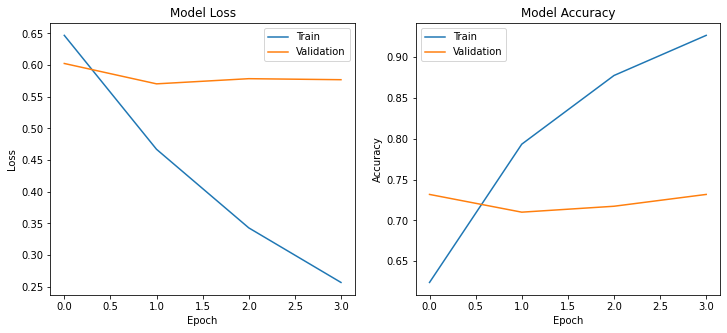

<Figure size 432x288 with 0 Axes>

In [ ]:
# create model
plt.subplots(1,2, figsize = (12,5))

# plot model loss
plt.subplot(1,2,1)
plt.plot(LV2_history['loss']) # train loss
plt.plot(LV2_history['val_loss']) # validation loss
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])

# plot model accuracy
plt.subplot(1,2,2)
plt.plot(LV2_history['binary_accuracy']) # train accuracy
plt.plot(LV2_history['val_binary_accuracy']) # validation accuracy
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

plt.tight_layout()
plt.show()

The confusion matrix is plotted below based on the filtered test dataset. The numbers shown in the table are the fraction of the total number of images for each class. The prediction accuracy of class 0 has improved greatly; however, it is still not as high as other classes.

This is understandable since both Class 0 and Class 6 look quite similar. The model is not expected to be able to perfectly tell them apart. 

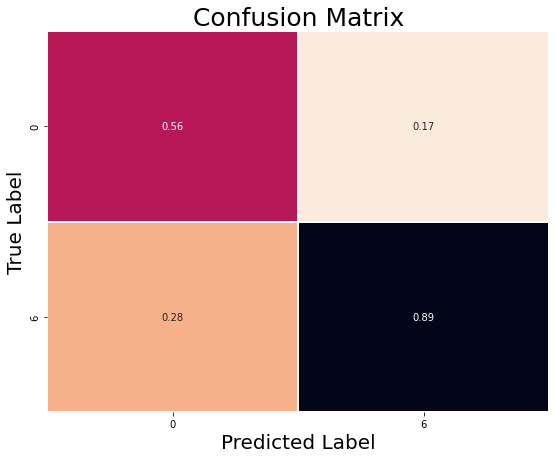

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
#Plot confusion matrix

# calculate the predicted labels for each test image.
predict_probas = LV2_model.predict(X_test_06)
y_predict = np.where(predict_probas < 0.5, 0,1) # use 50% threshold

# create the confusion matrix using sklearn 
conf_mat = confusion_matrix(y_test_06, y_predict)

# since we have many images, it is helpful to show our 
# results as fractions of the total number of images 
# for each class.
normalized_conf_mat = conf_mat / conf_mat.sum(axis=1)

plt.figure(figsize = (9,7))
sns.heatmap(normalized_conf_mat, # heatmap
            annot=True,
            cbar=False,
            cmap="rocket_r",
            linewidths=1,
            xticklabels=[0,6], yticklabels=[0,6]
           )
plt.title('Confusion Matrix',size = 25,y=1.01)
plt.xlabel("Predicted Label", size = 20)
plt.ylabel("True Label", size = 20)
plt.show()

### **6.3) Combined Model**<a class="anchor" id="sec63"></a>

We can combine **MODEL1** and **MODEL2** together to improve the overall prediction accuracy. Below is the work flow to use the combined model, which is coded within the `Combined_Model` function:

- STEP 1) Predict testing images using **MODEL1**
- STEP 2) Group all images that are predicted as Class 0 or Class 6
- STEP 3) Pass those images to **MODEL2** for new prediction
- STEP 4) Update the original prediction with the new prediction

We can see the updated confusion matrix based on the test dataset below with the improvement of Class 0 prediction.

In [ ]:
# function to run combined model
def Combined_Model(X_test, LV1_model, LV2_model, class1, class2): # class 1 input is "0" binary and class 2 input is "1" binary
    predict_probas_LV1 = LV1_model.predict(X_test) # original prediction prob at LV1
    y_predict_LV1 = np.argmax(predict_probas_LV1, axis=1) # original prediction at LV1

    index_pred_12 = [(y_predict_LV1 == class1) | (y_predict_LV1 == class2)] # index of predicted class 1 and class 2 

    predict_probas_LV2 = LV2_model.predict(X_test[index_pred_12]) # prediction prob at LV2
    y_predict_LV2 = np.where(predict_probas_LV2 < 0.5, class1, class2) # prediction at LV2
    y_predict_LV2 = y_predict_LV2.reshape(-1)  # flatten array


    y_predict_LV1[index_pred_12] = y_predict_LV2 # update prediction in LV1 from LV2

    return y_predict_LV1 # return updated prediction

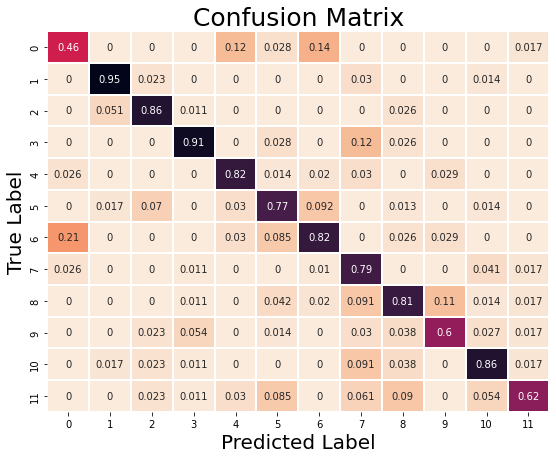

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
#Plot confusion matrix

# Calculate the predicted labels for each test image.
y_pred_new = Combined_Model(X_test, LV1_model, LV2_model, 0, 6)

conf_mat = confusion_matrix(y_test, y_pred_new)

# Since we have many images, it is helpful to show our 
# results as fractions of the total number of images 
# for each class.
normalized_conf_mat = conf_mat / conf_mat.sum(axis=1)

plt.figure(figsize = (9,7))
sns.heatmap(normalized_conf_mat,
            annot=True,
            cbar=False,
            cmap="rocket_r",
            linewidths=1
           )
plt.title('Confusion Matrix',size = 25,y=1.01)
plt.xlabel("Predicted Label", size = 20)
plt.ylabel("True Label", size = 20)
plt.show()

## **7) Evaluation**<a class="anchor" id="sec7"></a>

For model evaluation, we can extract some information from the `classification report` and summarize below:

|Score | MODEL1| Combined Model| Delta|
|--|:--:|:--:|:--:|
|Overall Precision (weighted avg)| 77%| 80%| 3%|
|Overall Recall (weighted avg)| 78%| 80%| 2%|
|Overall Accuracy| 78%| 80%| 2%|
|Class 0 Precision | 33%| 64%| 31%|
|Class 0 Recall| 10%| 46%| 36%|

The overall prediction scores increased slightly from **MODEL1** to the combined model. However, the prediction scores of Class 0 significantly increased. Therfore, we can say that the combined model works well to remediate the prediction problem with similar looking plants.

Note, ROC and AUC are great tools to compare the prediction of imbalanced classes. We should implement them in the future when we further fine-tune the model.

In [ ]:
from sklearn.metrics import classification_report

# classification Report of MODEL 1 
predict_probas = LV1_model.predict(X_test) # recalculate prediction probability
y_pred = np.argmax(predict_probas, axis=1)  # recalculate prediction

report_initial = classification_report(y_test, y_pred) # report
print(report_initial)

              precision    recall  f1-score   support

           0       0.33      0.10      0.16        39
           1       0.92      0.95      0.93        59
           2       0.84      0.86      0.85        43
           3       0.89      0.91      0.90        92
           4       0.79      0.82      0.81        33
           5       0.72      0.77      0.75        71
           6       0.65      0.83      0.73        98
           7       0.63      0.79      0.70        33
           8       0.76      0.81      0.78        78
           9       0.78      0.60      0.68        35
          10       0.84      0.86      0.85        74
          11       0.88      0.62      0.73        58

    accuracy                           0.78       713
   macro avg       0.75      0.74      0.74       713
weighted avg       0.77      0.78      0.76       713



In [ ]:
# classification Report of Combined Model
report_initial = classification_report(y_test, y_pred_new) # report
print(report_initial)

              precision    recall  f1-score   support

           0       0.64      0.46      0.54        39
           1       0.92      0.95      0.93        59
           2       0.84      0.86      0.85        43
           3       0.89      0.91      0.90        92
           4       0.79      0.82      0.81        33
           5       0.72      0.77      0.75        71
           6       0.74      0.82      0.78        98
           7       0.63      0.79      0.70        33
           8       0.76      0.81      0.78        78
           9       0.78      0.60      0.68        35
          10       0.84      0.86      0.85        74
          11       0.88      0.62      0.73        58

    accuracy                           0.80       713
   macro avg       0.79      0.77      0.77       713
weighted avg       0.80      0.80      0.79       713



In [ ]:
# MODEL1 accuracy
print(f'Model 1 accuracy = {(y_pred == y_test).sum()/len(y_test)}')

Model 1 accuracy = 0.7769985974754559


In [ ]:
# Combined Model accurcy
print(f'Combined Model 1 accuracy = {(y_pred_new == y_test).sum()/len(y_test)}')

Combined Model 1 accuracy = 0.7952314165497896


## **8) Explore Image Techniques**<a class="anchor" id="sec8"></a>

In this section we will compare various image techniques below:
- 1) Baseline (none)
- 2) Edge detection filter
- 3) Sharpen filter
- 4) Grey scale (1 color channel)
- 5) Grey scale with green enhanced (1 color channel)

For a quick assessment, we will use only 20% samples of the original dataset, and perform K-fold cross validation to calculate the validation accuracy.

**SPOILER:** We found that Baseline has the highest validation accuracy, so these image techniques are not experimented any further. You are still welcome to explore subsections below.

|Image Technique |Validation Accuracy (K-fold)|
|--|:--:|
|Baseline (none)| 49%|
|Edge Detection Filter| 20%|
|Sharpen Filter| 43%|
|Grey scale| 21%|
|Grey scale with green enhanced| 41%|

### **8.1) Baseline**<a class="anchor" id="sec81"></a>
For the baseline model, we use the same CNN model as **MODEL1**. However, we are not applying **ImageDataGenerator** in order to reduce the computational time. The average validation accuracy from the K-fold cross validation is 49%.

In [ ]:
# sample 20% data
X_sample, X_unused, y_sample, y_unused = train_test_split(X, y, test_size=0.70, stratify=y, random_state=111)

del X_unused # delete unused data
del y_unused # delete unused data

In [ ]:
# Run K-fold cross validation
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=5) # set 5 folds
val_acc = [] # empty list
count=0 # count fold
for train_index, test_index in skf.split(X_sample, y_sample): # split based on StratifiedKFold
    X_train4, y_train4 = X_sample[train_index], y_sample[train_index] # new training dataset
    X_val4,   y_val4 = X_sample[test_index] , y_sample[test_index] # new testing dataset

    IMAGE_SIZE = (224, 224, 3) # set input image size

    CNN_model = Sequential() # set model as sequential

    # create CNN model architecture with Pooling for dimensionality reduction 
    # and Dropout to reduce overfitting
    CNN_model.add(Conv2D(64, kernel_size=(3, 3), activation = 'relu', input_shape = IMAGE_SIZE))
    CNN_model.add(MaxPooling2D(pool_size=(2, 2)))
    CNN_model.add(Dropout(0.2))

    # create CNN model architecture with Pooling for dimensionality reduction 
    # and Dropout to reduce overfitting
    CNN_model.add(Conv2D(128, (3, 3), activation='relu'))
    CNN_model.add(MaxPooling2D(pool_size=(2, 2)))
    CNN_model.add(Dropout(0.20))

    # flatten the output of our convolutional layers
    CNN_model.add(Flatten())

    # add dense layers
    CNN_model.add(Dense(128, activation='relu'))
    CNN_model.add(Dense(64, activation='relu'))
    CNN_model.add(Dense(32, activation='relu'))
    CNN_model.add(Dense(12, activation='softmax'))

    # set optimizer and compile model
    opt = keras.optimizers.Adam(learning_rate=0.001)
    CNN_model.compile(loss = 'sparse_categorical_crossentropy',
                  optimizer = opt,
                  metrics = ['accuracy'])
  
    # fit model
    history = CNN_model.fit(X_train4, y_train4,
              batch_size = 64,
              epochs = 20,
              verbose = 0,
              validation_data=(X_val4, y_val4))
  
    val_acc.append(history.history['val_accuracy'][-1]) # save validation accuracy
    count = count+1
    print(f'validation accuracy of fold {count} is {val_acc[count-1]}') # print accuracy
print(f'The average validation accuracy is {pd.Series(val_acc).mean()}')

validation accuracy of fold 1 is 0.5228070020675659
validation accuracy of fold 2 is 0.6000000238418579
validation accuracy of fold 3 is 0.42456141114234924
validation accuracy of fold 4 is 0.5719298124313354
validation accuracy of fold 5 is 0.3309859037399292
The average validation accuracy is 0.49005683064460753


### **8.2) Edge Detection Filter**<a class="anchor" id="sec82"></a>

The edge detection filter is defined then applied to the sample dataset. Below we can see the comparison between an original image and a filtered image.

In [ ]:
# edge detection filter
edge_detection_filter = np.array([
    [-1,-1,-1],
    [-1, 8,-1],
    [-1,-1,-1]])

In [ ]:
# create place holder for filterd images
conv_image = X_sample.copy()*0
temp_image = np.zeros([X_sample.shape[1]+2,X_sample.shape[2]+2,3])

In [ ]:
from scipy import signal
import cv2 

# apply filter in all 3 channels 
for i in np.arange(len(X_sample)):
  
    temp_image[:,:,0] = signal.convolve2d(X_sample[i, :, :, 0], edge_detection_filter)
    temp_image[:,:,1] = signal.convolve2d(X_sample[i, :, :, 1], edge_detection_filter)
    temp_image[:,:,2] = signal.convolve2d(X_sample[i, :, :, 2], edge_detection_filter)

    # save filtered images
    conv_image[i] = cv2.resize(temp_image, (224,224))

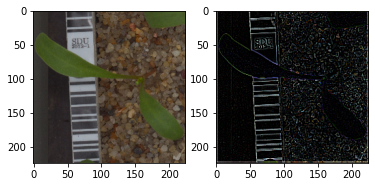

In [ ]:
plt.subplots(1,2)
# plot original image
plt.subplot(1,2,1)
plt.imshow(X_sample[0])
# plot edge detection filterd image
plt.subplot(1,2,2)
plt.imshow(conv_image[0])

The average validation accuracy from the K-fold cross validation is 20%.

In [ ]:
# Run K-fold cross validation
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=5) # set 5 folds
val_acc = [] # empty list
count=0 # count fold
for train_index, test_index in skf.split(conv_image, y_sample): # split based on StratifiedKFold
    X_train4, y_train4 = conv_image[train_index], y_sample[train_index] # new training dataset
    X_val4,   y_val4 = conv_image[test_index] , y_sample[test_index] # new testing dataset

    IMAGE_SIZE = (224, 224, 3) # set input image size

    CNN_model = Sequential() # set model as sequential

    # create CNN model architecture with Pooling for dimensionality reduction 
    # and Dropout to reduce overfitting
    CNN_model.add(Conv2D(64, kernel_size=(3, 3), activation = 'relu', input_shape = IMAGE_SIZE))
    CNN_model.add(MaxPooling2D(pool_size=(2, 2)))
    CNN_model.add(Dropout(0.2))

    # create CNN model architecture with Pooling for dimensionality reduction 
    # and Dropout to reduce overfitting
    CNN_model.add(Conv2D(128, (3, 3), activation='relu'))
    CNN_model.add(MaxPooling2D(pool_size=(2, 2)))
    CNN_model.add(Dropout(0.20))

    # flatten the output of our convolutional layers
    CNN_model.add(Flatten())

    # add dense layers
    CNN_model.add(Dense(128, activation='relu'))
    CNN_model.add(Dense(64, activation='relu'))
    CNN_model.add(Dense(32, activation='relu'))
    CNN_model.add(Dense(12, activation='softmax'))

    # set optimizer and compile model
    opt = keras.optimizers.Adam(learning_rate=0.001)
    CNN_model.compile(loss = 'sparse_categorical_crossentropy',
                  optimizer = opt,
                  metrics = ['accuracy'])
  
    # fit model
    history = CNN_model.fit(X_train4, y_train4,
              batch_size = 64,
              epochs = 20,
              verbose = 0,
              validation_data=(X_val4, y_val4))
  
    val_acc.append(history.history['val_accuracy'][-1]) # save validation accuracy
    count = count+1
    print(f'validation accuracy of fold {count} is {val_acc[count-1]}') # print accuracy
print(f'The average validation accuracy is {pd.Series(val_acc).mean()}')

validation accuracy of fold 1 is 0.24210526049137115
validation accuracy of fold 2 is 0.16491228342056274
validation accuracy of fold 3 is 0.15789473056793213
validation accuracy of fold 4 is 0.2175438553094864
validation accuracy of fold 5 is 0.21478873491287231
The average validation accuracy is 0.19944897294044495


### **8.3) Sharpen Filter**<a class="anchor" id="sec83"></a>

The sharpen filter is defined then applied to the sample dataset. Below we can see the comparison between an original image and a filtered image.

In [ ]:
# sharpen filter
sharpen_filter = np.array([
    [ 0,-1, 0],
    [-1, 5,-1],
    [ 0,-1, 0]])

In [ ]:
# create place holder for filterd images
conv_image = X_sample.copy()*0
temp_image = np.zeros([X_sample.shape[1]+2,X_sample.shape[2]+2,3])

In [ ]:
from scipy import signal
import cv2 

# apply filter in all 3 channels 
for i in np.arange(len(X_sample)):
  
  temp_image[:,:,0] = signal.convolve2d(X_sample[i, :, :, 0], sharpen_filter)
  temp_image[:,:,1] = signal.convolve2d(X_sample[i, :, :, 1], sharpen_filter)
  temp_image[:,:,2] = signal.convolve2d(X_sample[i, :, :, 2], sharpen_filter)

  # save filtered images
  conv_image[i] = cv2.resize(temp_image, (224,224))

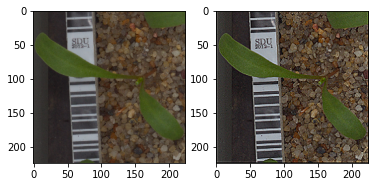

In [ ]:
plt.subplots(1,2)
# plot original image
plt.subplot(1,2,1)
plt.imshow(X_sample[0])
# plot edge detection filterd image
plt.subplot(1,2,2)
plt.imshow(conv_image[0])

The average validation accuracy from the K-fold cross validation is 43%.

In [ ]:
# Run K-fold cross validation
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=5) # set 5 folds
val_acc = [] # empty list
count=0 # count fold
for train_index, test_index in skf.split(conv_image, y_sample): # split based on StratifiedKFold
    X_train4, y_train4 = conv_image[train_index], y_sample[train_index] # new training dataset
    X_val4,   y_val4 = conv_image[test_index] , y_sample[test_index] # new testing dataset

    IMAGE_SIZE = (224, 224, 3) # set input image size

    CNN_model = Sequential() # set model as sequential

    # create CNN model architecture with Pooling for dimensionality reduction 
    # and Dropout to reduce overfitting
    CNN_model.add(Conv2D(64, kernel_size=(3, 3), activation = 'relu', input_shape = IMAGE_SIZE))
    CNN_model.add(MaxPooling2D(pool_size=(2, 2)))
    CNN_model.add(Dropout(0.2))

    # create CNN model architecture with Pooling for dimensionality reduction 
    # and Dropout to reduce overfitting
    CNN_model.add(Conv2D(128, (3, 3), activation='relu'))
    CNN_model.add(MaxPooling2D(pool_size=(2, 2)))
    CNN_model.add(Dropout(0.20))

    # flatten the output of our convolutional layers
    CNN_model.add(Flatten())

    # add dense layers
    CNN_model.add(Dense(128, activation='relu'))
    CNN_model.add(Dense(64, activation='relu'))
    CNN_model.add(Dense(32, activation='relu'))
    CNN_model.add(Dense(12, activation='softmax'))

    # set optimizer and compile model
    opt = keras.optimizers.Adam(learning_rate=0.001)
    CNN_model.compile(loss = 'sparse_categorical_crossentropy',
                  optimizer = opt,
                  metrics = ['accuracy'])
  
    # fit model
    history = CNN_model.fit(X_train4, y_train4,
              batch_size = 64,
              epochs = 20,
              verbose = 0,
              validation_data=(X_val4, y_val4))
  
    val_acc.append(history.history['val_accuracy'][-1]) # save validation accuracy
    count = count+1
    print(f'validation accuracy of fold {count} is {val_acc[count-1]}') # print accuracy
print(f'The average validation accuracy is {pd.Series(val_acc).mean()}')

validation accuracy of fold 1 is 0.340350866317749
validation accuracy of fold 2 is 0.5894736647605896
validation accuracy of fold 3 is 0.30877193808555603
validation accuracy of fold 4 is 0.49473685026168823
validation accuracy of fold 5 is 0.4154929518699646
The average validation accuracy is 0.4297652542591095


### **8.4) Grey Scale**<a class="anchor" id="sec84"></a>

Color images can be easily converted to grey scale images. The formula for the conversion is (R+G+B)/3. Below we can see the comparison between an original image and a converted image.

In [ ]:
# gray scale conversion
gray_images = np.zeros((X_sample.shape[0],X_sample.shape[1],X_sample.shape[2]), dtype=int)
gray_images = gray_images.astype('float32')

for i in np.arange(len(X_sample)):
  
    r_image = X_sample[i, :, :, 0].astype('float32')
    g_image = X_sample[i, :, :, 1].astype('float32')
    b_image = X_sample[i, :, :, 2].astype('float32')
    gray_images[i] = (r_image+g_image+b_image)/3


gray_images = gray_images.reshape(gray_images.shape[0],gray_images.shape[1],gray_images.shape[2],1)
conv_image = gray_images.copy()

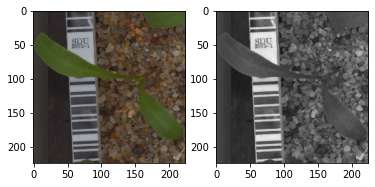

In [ ]:
plt.subplots(1,2)
# plot original image
plt.subplot(1,2,1)
plt.imshow(X_sample[0])
# plot edge detection filterd image
plt.subplot(1,2,2)
plt.imshow(conv_image[0,:,:,0], cmap='gray')

The average validation accuracy from the K-fold cross validation is 21%

In [ ]:
# Run K-fold cross validation
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=5) # set 5 folds
val_acc = [] # empty list
count=0 # count fold
for train_index, test_index in skf.split(conv_image, y_sample): # split based on StratifiedKFold
    X_train4, y_train4 = conv_image[train_index], y_sample[train_index] # new training dataset
    X_val4,   y_val4 = conv_image[test_index] , y_sample[test_index] # new testing dataset

    IMAGE_SIZE = (224, 224, 1) # set input image size

    CNN_model = Sequential() # set model as sequential

    # create CNN model architecture with Pooling for dimensionality reduction 
    # and Dropout to reduce overfitting
    CNN_model.add(Conv2D(64, kernel_size=(3, 3), activation = 'relu', input_shape = IMAGE_SIZE))
    CNN_model.add(MaxPooling2D(pool_size=(2, 2)))
    CNN_model.add(Dropout(0.2))

    # create CNN model architecture with Pooling for dimensionality reduction 
    # and Dropout to reduce overfitting
    CNN_model.add(Conv2D(128, (3, 3), activation='relu'))
    CNN_model.add(MaxPooling2D(pool_size=(2, 2)))
    CNN_model.add(Dropout(0.20))

    # flatten the output of our convolutional layers
    CNN_model.add(Flatten())

    # add dense layers
    CNN_model.add(Dense(128, activation='relu'))
    CNN_model.add(Dense(64, activation='relu'))
    CNN_model.add(Dense(32, activation='relu'))
    CNN_model.add(Dense(12, activation='softmax'))

    # set optimizer and compile model
    opt = keras.optimizers.Adam(learning_rate=0.001)
    CNN_model.compile(loss = 'sparse_categorical_crossentropy',
                  optimizer = opt,
                  metrics = ['accuracy'])
  
    # fit model
    history = CNN_model.fit(X_train4, y_train4,
              batch_size = 64,
              epochs = 20,
              verbose = 0,
              validation_data=(X_val4, y_val4))
  
    val_acc.append(history.history['val_accuracy'][-1]) # save validation accuracy
    count = count+1
    print(f'validation accuracy of fold {count} is {val_acc[count-1]}') # print accuracy
print(f'The average validation accuracy is {pd.Series(val_acc).mean()}')

validation accuracy of fold 1 is 0.1859649121761322
validation accuracy of fold 2 is 0.19298245012760162
validation accuracy of fold 3 is 0.19649122655391693
validation accuracy of fold 4 is 0.20701754093170166
validation accuracy of fold 5 is 0.246478870511055
The average validation accuracy is 0.2057870000600815


### **8.5) Grey Scale with Green Enhanced**<a class="anchor" id="sec85"></a>

Grey scale with green enhanced makes the green color from the original image bright and dims other colors. The formula for the conversion is G/(R+G+B). Below we can see the comparison between an original image and a converted image.


In [ ]:
# green enhanced conversion
green_images = np.zeros((X_sample.shape[0],X_sample.shape[1],X_sample.shape[2]), dtype=int)
green_images = green_images.astype('float32')

for i in np.arange(len(X_sample)):
  
    r_image = X_sample[i, :, :, 0].astype('float32')+0.01 # add 0.01 to avoid Nan
    g_image = X_sample[i, :, :, 1].astype('float32')
    b_image = X_sample[i, :, :, 2].astype('float32')
    green_images[i] = g_image/(r_image+g_image+b_image)


green_images = green_images.reshape(green_images.shape[0],green_images.shape[1],green_images.shape[2],1)
conv_image = green_images.copy()

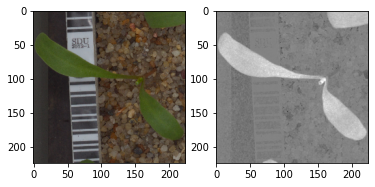

In [ ]:
plt.subplots(1,2)
# plot original image
plt.subplot(1,2,1)
plt.imshow(X_sample[0])
# plot edge detection filterd image
plt.subplot(1,2,2)
plt.imshow(conv_image[0,:,:,0], cmap='gray')

The average validation accuracy from the K-fold cross validation is 41%.

In [ ]:
# Run K-fold cross validation
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=5) # set 5 folds
val_acc = [] # empty list
count=0 # count fold
for train_index, test_index in skf.split(conv_image, y_sample): # split based on StratifiedKFold
    X_train4, y_train4 = conv_image[train_index], y_sample[train_index] # new training dataset
    X_val4,   y_val4 = conv_image[test_index] , y_sample[test_index] # new testing dataset

    IMAGE_SIZE = (224, 224, 1) # set input image size

    CNN_model = Sequential() # set model as sequential

    # create CNN model architecture with Pooling for dimensionality reduction 
    # and Dropout to reduce overfitting
    CNN_model.add(Conv2D(64, kernel_size=(3, 3), activation = 'relu', input_shape = IMAGE_SIZE))
    CNN_model.add(MaxPooling2D(pool_size=(2, 2)))
    CNN_model.add(Dropout(0.2))

    # create CNN model architecture with Pooling for dimensionality reduction 
    # and Dropout to reduce overfitting
    CNN_model.add(Conv2D(128, (3, 3), activation='relu'))
    CNN_model.add(MaxPooling2D(pool_size=(2, 2)))
    CNN_model.add(Dropout(0.20))

    # flatten the output of our convolutional layers
    CNN_model.add(Flatten())

    # add dense layers
    CNN_model.add(Dense(128, activation='relu'))
    CNN_model.add(Dense(64, activation='relu'))
    CNN_model.add(Dense(32, activation='relu'))
    CNN_model.add(Dense(12, activation='softmax'))

    # set optimizer and compile model
    opt = keras.optimizers.Adam(learning_rate=0.001)
    CNN_model.compile(loss = 'sparse_categorical_crossentropy',
                  optimizer = opt,
                  metrics = ['accuracy'])
  
    # fit model
    history = CNN_model.fit(X_train4, y_train4,
              batch_size = 64,
              epochs = 20,
              verbose = 0,
              validation_data=(X_val4, y_val4))
  
    val_acc.append(history.history['val_accuracy'][-1]) # save validation accuracy
    count = count+1
    print(f'validation accuracy of fold {count} is {val_acc[count-1]}') # print accuracy
print(f'The average validation accuracy is {pd.Series(val_acc).mean()}')

validation accuracy of fold 1 is 0.4350877106189728
validation accuracy of fold 2 is 0.4000000059604645
validation accuracy of fold 3 is 0.45614033937454224
validation accuracy of fold 4 is 0.42456141114234924
validation accuracy of fold 5 is 0.34859153628349304
The average validation accuracy is 0.41287620067596437


## **9) Conclusions**<a class="anchor" id="sec9"></a>

In this notebook, we imported pre-clean images and labels from another notebook. We then performed detailed data review, further cleaning, and EDA. The dataset was used to train, validate and test 3 CNN models (MODEL1, MODEL2, and Combined Model). The final combined model was able to acheived 80% test accuracy, 80% precision, and 80% recall. Other important insigts are summarized in key points below:
- During EDA, we found that the number of images in each classes are quite imbalance.
- From reviewing the images, it was noticed that Class 0, 4, and 6 (Black-grass, Common wheat, and Loose Silky-bent) have similar leave features which can cause difficulties to the model. Other plants have unique features when they are grown, but those feature may not appear when they are in a young stage, which can also contribute to misprediction. 
- During the model development, MODEL1 preformed relatively well except for Class 0, which was misclassified frequently with Class 6.
- MODEL2 was trained speficially to tell the difference between Class 0 and Class 6 to improve the prediction of MODEL1.
- 4 image techniques were experimented including edge detection filter, sharpen filter, grey scale, and grey scale with green enhance, but none of them were able to improve the prediction accuracy.

This project provides a foundation for creating a CNN model to classify plant images. We can use the model from this project as a starting model for the intelligent farming system to be prototyped in Thailand. We have also learned a technique to deal with similar plants, which can be valuable when we come across a similar problem.

## **10) Recommendations**<a class="anchor" id="sec10"></a>



- 1) Further improve the model by finetuning the hyper parameters and explore other techniques such as:
  - adding / removing various type of layers in the CNN model
  - apply SMOTE to deal with imblanced data
  - try other transfer learning models and pre-trained weights
  - use ROC and AUC to help evaluate the model
- 2) Better understand by where model makes wrong predictions
- 3) Implement this model in a real-world scenario (e.g. using drone images)